In [ ]:
import  numpy as np
import  math
from    numba import cuda, float32

In [ ]:
@cuda.jit(device=True)
def normalize_vector(input_array):
    """
    Normalizes the given input array in place.

    Parameters:
    - input_array: array-like object representing a vector.
                   Assumes the array is allocated on device memory.
    """
    # Compute the norm of the vector
    norm = float32(0.0)
    for i in range(len(input_array)):  # Use the dynamic length of the array
        norm += input_array[i] ** 2
    norm = math.sqrt(norm)  # Use math.sqrt for compatibility with device functions

    # Normalize the vector components
    if norm > 0:  # Avoid division by zero
        for i in range(len(input_array)):
            input_array[i] /= norm

In [ ]:
from numba import cuda

@cuda.jit(device=True)
def dot_product(a, b):
    """
    Calculate the dot product of two vectors of the same length.

    Parameters:
    - a: array-like object, first input vector.
    - b: array-like object, second input vector.
         Assumes both arrays have the same length.
    """
    result = 0.0
    for i in range(len(a)):  # Iterate dynamically over the length of the input vectors
        result += a[i] * b[i]
    return result

In [ ]:
@cuda.jit(device=True)
def ray_sphere_intersection(ray_origin, ray_direction, center, radius):
    """
    Perform ray-sphere intersection test.

    Parameters:
    - ray_origin: array-like, origin of the ray.
    - ray_direction: array-like, direction of the ray (normalized).
    - center: array-like, center of the sphere.
    - radius: float, radius of the sphere.

    Returns:
    - t: float, the distance to the intersection point. Returns a large value if no intersection.
    - hit: bool, whether the ray intersects the sphere.
    """
    oc = cuda.local.array(3, dtype=float32)
    for i in range(3):
        oc[i] = ray_origin[i] - center[i]

    a = dot_product(ray_direction, ray_direction)
    b = 2.0 * dot_product(oc, ray_direction)
    c = dot_product(oc, oc) - radius * radius
    discriminant = b * b - 4 * a * c

    if discriminant > 0.0:
        t = (-b - math.sqrt(discriminant)) / (2.0 * a)
        if t > 0.001:  # Avoid near-zero intersections
            return t, True
    return float('inf'), False

In [ ]:
@cuda.jit
def render(image, width, height, spheres, num_spheres):
    """
    Kernel to render the scene by testing ray-sphere intersections.
    """
    x, y = cuda.grid(2)
    if x >= width or y >= height:
        return

    idx = y * width + x
    u = x / width
    v = y / height

    # Ray origin
    ray_origin = cuda.local.array(3, dtype=float32)
    ray_origin[0] = 0.
    ray_origin[1] = 0.
    ray_origin[2] = 0.

    # Ray direction
    ray_direction = cuda.local.array(3, dtype=float32)
    ray_direction[0] = 2.0 * u - 1.0
    ray_direction[1] = 2.0 * v - 1.0
    ray_direction[2] = -1.0

    normalize_vector(ray_direction)

    color = cuda.local.array(3, dtype=float32)
    color[0] = 0.
    color[1] = 0.
    color[2] = 0.

    closest_t = float('inf')

    for i in range(num_spheres):
        center = spheres[i, :3]
        radius = spheres[i, 3]

        t, hit = ray_sphere_intersection(ray_origin, ray_direction, center, radius)
        if hit and t < closest_t:
            closest_t = t
            for j in range(3):
                hit_point = ray_origin[j] + t * ray_direction[j]
                normal = (hit_point - center[j]) / radius
                color[j] = 0.5 * (normal + 1.0)  # Map normals to RGB

    image[idx, 0] = color[0]
    image[idx, 1] = color[1]
    image[idx, 2] = color[2]

In [ ]:
# Sphere properties: x, y, z, radius
spheres_data = np.array([
    [0.0, 0.0, -1.0, 0.5],  # Sphere 1
    [1.0, 0.0, -1.5, 0.5],  # Sphere 2
], dtype=np.float32)

In [ ]:
# Image dimensions
width, height = 800, 400
threads_per_block = (16, 16)
blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

In [ ]:
# Allocate memory for the image
image       = np.zeros((width * height, 3), dtype=np.float32)
image_gpu   = cuda.to_device(image)
spheres_gpu = cuda.to_device(spheres_data)

In [ ]:
# Launch the kernel
print(blocks_per_grid)
print(threads_per_block)
render[blocks_per_grid, threads_per_block](image_gpu, width, height, spheres_gpu, len(spheres_data))

(50, 25)
(16, 16)


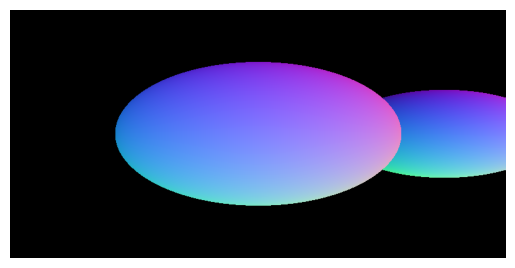

In [ ]:
# Copy the result back to host
image_gpu.copy_to_host(image)

# Reshape and save
image = image.reshape((height, width, 3))
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')
plt.show()